In [36]:
import os
import numpy as np
import pandas as pd
import torch
import shutil
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import json
import glob
import random
from PIL import Image
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision import models
from torchvision.models import ResNet50_Weights
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
base_dir = 'C:/Users/'
train_dir = os.path.join(base_dir, "images_filtered_train")
val_dir = os.path.join(base_dir, "images_filtered_val")
test_dir = os.path.join(base_dir, 'images_filtered_test')

In [3]:
num_train_images = len(glob.glob(train_dir + '/*/*.jpg'))
num_val_images = len(glob.glob(val_dir + '/*/*.jpg'))
num_test_images = len(glob.glob(test_dir + '/*/*.jpg'))

print('Total training images:', num_train_images)
print('Total validation images:', num_val_images)
print('Total test images:', num_test_images)
print('Total de imagens:', num_train_images+num_val_images+num_test_images)

Total training images: 192642
Total validation images: 24174
Total test images: 24169
Total de imagens: 240985


In [5]:
def listar_subdiretorios(dir):
    return [os.path.join(dir, nome) 
        for nome in os.listdir(dir) 
            if os.path.isdir(os.path.join(dir, nome))]

# Listar subdiretórios em train, val e test
train_subdirs = listar_subdiretorios(train_dir)
val_subdirs = listar_subdiretorios(val_dir)
test_subdirs = listar_subdiretorios(test_dir)

In [7]:
with open('C:/Users/new_names.json') as f:
    data_json = json.load(f)

### Verificando nome e quantidade de plantas presentes em cada diretório de Treino

In [13]:
def count_images_in_directories(directories, plant_dict):
    counts = {}
    total_images = 0

    for dir_path in directories:
        plant_name = os.path.basename(dir_path)

        # Verifica se o nome da planta está no dicionário
        if plant_name in plant_dict.values():
            image_count = sum(os.path.isfile(os.path.join(dir_path, f)) for f in os.listdir(dir_path))
            counts[plant_name] = image_count
            total_images += image_count
        else:
            print(f"Planta '{plant_name}' não encontrada no dicionário.")

    return counts, total_images

image_counts, total_images = count_images_in_directories(train_subdirs, data_json)

for plant_name, count in image_counts.items():
    print(f"Planta: {plant_name}, Quantidade de imagens: {count}")
print(f"Total de imagens: {total_images}")

Planta: Acacia_dealbata, Quantidade de imagens: 1028
Planta: Acalypha_wilkesiana, Quantidade de imagens: 239
Planta: Aegopodium_podagraria, Quantidade de imagens: 2385
Planta: Alcea_rosea, Quantidade de imagens: 4285
Planta: Alliaria_petiolata, Quantidade de imagens: 6337
Planta: Alocasia_macrorrhizos, Quantidade de imagens: 280
Planta: Alocasia_sanderiana, Quantidade de imagens: 357
Planta: Althaea_officinalis, Quantidade de imagens: 744
Planta: Anemone_alpina, Quantidade de imagens: 1348
Planta: Anemone_blanda, Quantidade de imagens: 456
Planta: Anemone_coronaria, Quantidade de imagens: 677
Planta: Anemone_hepatica, Quantidade de imagens: 1899
Planta: Anemone_hortensis, Quantidade de imagens: 351
Planta: Anemone_hupehensis, Quantidade de imagens: 2200
Planta: Anemone_narcissiflora, Quantidade de imagens: 202
Planta: Anemone_nemorosa, Quantidade de imagens: 3388
Planta: Anemone_pulsatilla, Quantidade de imagens: 646
Planta: Anemone_ranunculoides, Quantidade de imagens: 479
Planta: Ane

### Percentual da divisão do dataset

In [16]:
def cont_image(directory):
    return sum(len(files) for _, _, files in os.walk(directory))
    
train_cont, val_cont, test_cont = map(cont_image, [train_dir, val_dir, test_dir])

total_images = train_cont + val_cont + test_cont

print(f"Treino: {train_cont} imagens ({train_cont / total_images:.2%})")
print(f"Validação: {val_cont} imagens ({val_cont / total_images:.2%})")
print(f"Teste: {test_cont} imagens ({test_cont / total_images:.2%})")

Treino: 192642 imagens (79.94%)
Validação: 24174 imagens (10.03%)
Teste: 24169 imagens (10.03%)


### Definindo um Pipeline de tranformação para os dados de treino e validação. Pipeline na documentação do Pytorch

In [17]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

image_datasets = {
    'train': datasets.ImageFolder(root=train_dir, transform=data_transforms['train']),
    'val': datasets.ImageFolder(root=val_dir, transform=data_transforms['val'])
}

# DataLoaders para carregar os dados em lotes
dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4)
    for x in ['train', 'val']
}

In [20]:
# Verificar as classes e definir o número de classes
class_names = image_datasets['train'].classes

num_classes = len(class_names)  

#print(f"Classes encontradas: {class_names}")
print(f"Quantidade de classes: {num_classes}")

Quantidade de classes: 154


### Carregando o modelo ResNet50 com os pesos recentes.

In [23]:
model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

# Congelar as camadas convolucionais
for param in model.parameters():
    param.requires_grad = False

# Substituir a última camada para o número correto de classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

# Enviando o modelo para a GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

### Definindo função de perda e otimizador

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

### Realização do primeiro treinamento definindo 20 epochs de inicio

In [26]:
def train_model(model, criterion, optimizer, dataloaders, device, num_epochs=20):
    model.train()

    for epoch in range(num_epochs):
        total_loss, total_corrects = 0, 0

        for inputs, labels in dataloaders['train']:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward pass e cálculo da perda
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass e otimização
            loss.backward()
            optimizer.step()

            # Estatística
            total_loss += loss.item() * inputs.size(0)
            total_corrects += (outputs.argmax(1) == labels).sum().item()

        # Cálculo da perda e acurácia média da época
        epoch_loss = total_loss / len(dataloaders['train'].dataset)
        epoch_acc = total_corrects / len(dataloaders['train'].dataset)

        print(f"Epoch {epoch}/{num_epochs - 1} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

train_model(model, criterion, optimizer, dataloaders, device, num_epochs=20)

Epoch 0/19 - Loss: 1.7702, Accuracy: 0.5707
Epoch 1/19 - Loss: 1.4350, Accuracy: 0.6419
Epoch 2/19 - Loss: 1.3446, Accuracy: 0.6619
Epoch 3/19 - Loss: 1.2846, Accuracy: 0.6758
Epoch 4/19 - Loss: 1.2364, Accuracy: 0.6861
Epoch 5/19 - Loss: 1.2010, Accuracy: 0.6931
Epoch 6/19 - Loss: 1.1667, Accuracy: 0.7006
Epoch 7/19 - Loss: 1.1444, Accuracy: 0.7067
Epoch 8/19 - Loss: 1.1179, Accuracy: 0.7123
Epoch 9/19 - Loss: 1.0958, Accuracy: 0.7175
Epoch 10/19 - Loss: 1.0771, Accuracy: 0.7212
Epoch 11/19 - Loss: 1.0564, Accuracy: 0.7243
Epoch 12/19 - Loss: 1.0438, Accuracy: 0.7267
Epoch 13/19 - Loss: 1.0256, Accuracy: 0.7315
Epoch 14/19 - Loss: 1.0123, Accuracy: 0.7339
Epoch 15/19 - Loss: 0.9953, Accuracy: 0.7379
Epoch 16/19 - Loss: 0.9868, Accuracy: 0.7397
Epoch 17/19 - Loss: 0.9754, Accuracy: 0.7421
Epoch 18/19 - Loss: 0.9679, Accuracy: 0.7448
Epoch 19/19 - Loss: 0.9588, Accuracy: 0.7466


### Avaliando o conjunto de validação com acurácia

In [27]:
def evaluate_model(model, dataloaders, device):
    model.eval()
    total_corrects = 0

    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            preds = outputs.argmax(1)
            total_corrects += (preds == labels).sum().item()

    accuracy = total_corrects / len(dataloaders['val'].dataset)
    print(f'Validation Accuracy: {accuracy:.4f}')

evaluate_model(model, dataloaders, device)

Validation Accuracy: 0.6989


### Recal, F1-score e precision

In [30]:
def evaluate_model_with_metrics(model, dataloaders, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            preds = outputs.argmax(1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Relatório de classificação
    print(classification_report(all_labels, all_preds, target_names=class_names))

class_names = dataloaders['train'].dataset.classes
evaluate_model_with_metrics(model, dataloaders, device, class_names)

                              precision    recall  f1-score   support

             Acacia_dealbata       0.66      0.76      0.71       129
         Acalypha_wilkesiana       0.55      0.73      0.63        30
       Aegopodium_podagraria       0.67      0.67      0.67       299
                 Alcea_rosea       0.75      0.79      0.77       536
          Alliaria_petiolata       0.81      0.78      0.80       793
       Alocasia_macrorrhizos       0.95      0.57      0.71        35
         Alocasia_sanderiana       0.90      0.96      0.92        45
         Althaea_officinalis       0.48      0.43      0.45        94
              Anemone_alpina       0.71      0.63      0.67       169
              Anemone_blanda       0.83      0.51      0.63        57
           Anemone_coronaria       0.67      0.52      0.58        85
            Anemone_hepatica       0.95      0.64      0.76       238
           Anemone_hortensis       1.00      0.41      0.58        44
          Anemone_h

### Média ponderada das metricas anteriores

In [31]:
def evaluate_model_with_metrics(model, dataloaders, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            preds = outputs.argmax(1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calcular métricas
    f1 = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')

    print(f'F1 Score: {f1:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')

evaluate_model_with_metrics(model, dataloaders, device)

F1 Score: 0.7023
Precision: 0.7531
Recall: 0.6989


### Salvando modelo e pesos do treinamento

In [33]:
torch.save(model.state_dict(), 'C:/Users/GitHub/pesos_it_1.pth')
torch.save(model, 'C:/Users/GitHub/modelo_it_1.pth')

In [34]:
model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

# Carregando os pesos salvos
model.load_state_dict(torch.load('C:/Users/GitHub/pesos_it_1.pth',weights_only=True))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Avaliação do modelo ultilizando transfer learning em uma imagem nunca vista antes

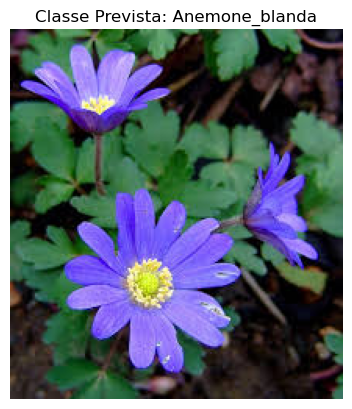

In [40]:
# Carregar e transformar a imagem
def carregar_e_transformar_imagem(caminho_imagem):
    imagem = Image.open(caminho_imagem).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    return imagem, transform(imagem).unsqueeze(0).to(device)

caminho_imagem = "C:/Users/teste_imagens/images.jpg"

# Carregar, transformar e plotar a imagem
imagem_original, input_tensor = carregar_e_transformar_imagem(caminho_imagem)

model = model.to(device)

class_names = image_datasets['train'].classes

# Fazendo a previsão
with torch.no_grad():
    output = model(input_tensor)
    _, predicted = torch.max(output, 1)

classe_prevista = class_names[predicted.item()]

plt.imshow(imagem_original)
plt.title(f"Classe Prevista: {classe_prevista}")
plt.axis('off')
plt.show()